## CMPINF 2130 Summer 2021 - Week 07

### Comparing averages across groups

## Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

## Load mpg data

In [2]:
url_mpg = 'https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/ggplot2/mpg.csv'

mpg = pd.read_csv(url_mpg, index_col=0)

In [3]:
mpg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234 entries, 1 to 234
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  234 non-null    object 
 1   model         234 non-null    object 
 2   displ         234 non-null    float64
 3   year          234 non-null    int64  
 4   cyl           234 non-null    int64  
 5   trans         234 non-null    object 
 6   drv           234 non-null    object 
 7   cty           234 non-null    int64  
 8   hwy           234 non-null    int64  
 9   fl            234 non-null    object 
 10  class         234 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 21.9+ KB


## Condition on categorical variable

Compare the distribution of of `hwy` conditioned on the unique values of `drv`. First look at the eCDF for `hwy` conditioned on each unique value of `drv`.

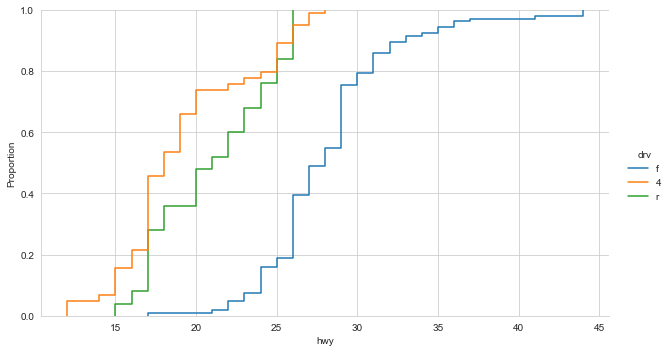

In [4]:
sns.set_style('whitegrid')

sns.displot(data = mpg, x='hwy', hue='drv', kind='ecdf', aspect=1.75)

plt.show()

Next, look at density estimates to better examine the shape of distributions. 

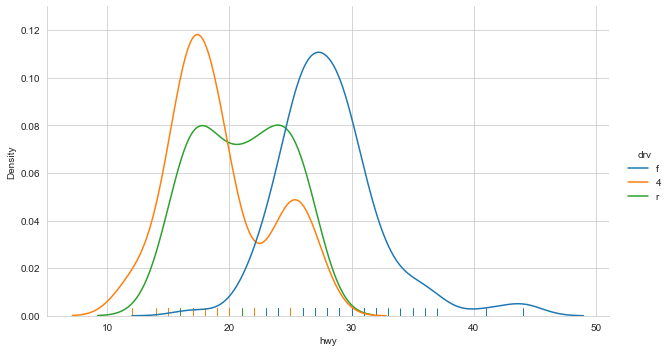

In [5]:
sns.displot(data = mpg, x='hwy', hue='drv', kind='kde', rug=True, aspect=1.75,
            common_norm=False)

plt.show()

Alternatively we can compare the distributions across groups using a violin plot.

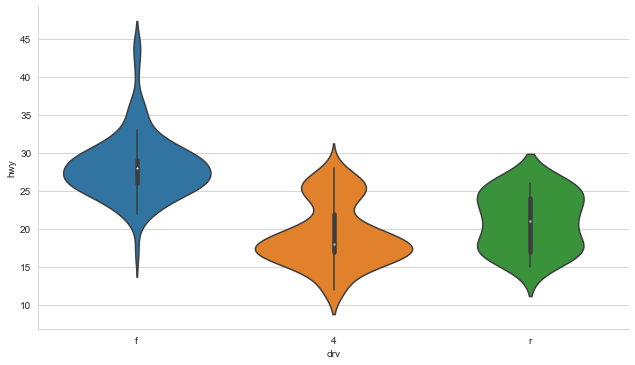

In [6]:
sns.catplot(data = mpg, x='drv', y='hwy', kind='violin', aspect = 1.75)

plt.show()

By default a simplified boxplot is shown in the "interior" of the violin. We can change that with the `inner` argument. We can show the quartiles as horizontal lines, and thus just visualize the main components of the boxplot.

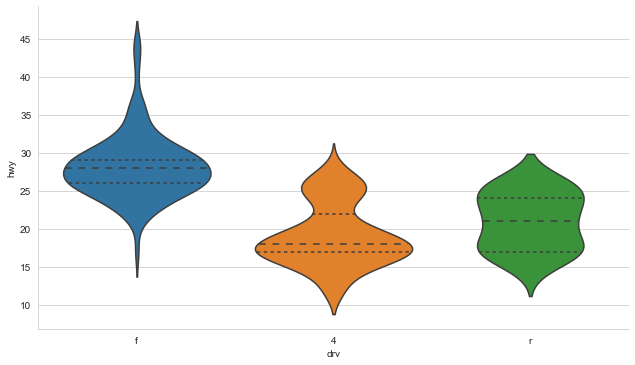

In [7]:
sns.catplot(data = mpg, x='drv', y='hwy', kind='violin', inner='quartile', aspect = 1.75)

plt.show()

Or we can show the observations, though the data are not jittered.

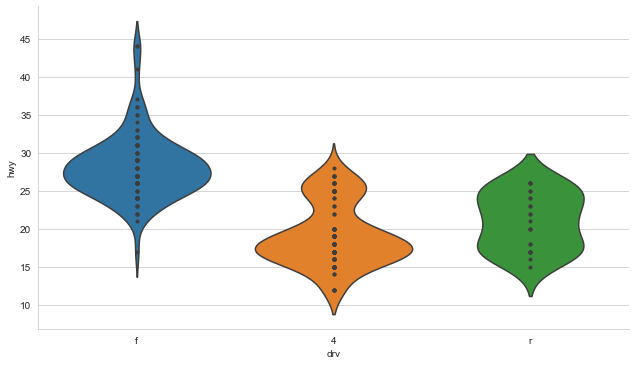

In [8]:
sns.catplot(data = mpg, x='drv', y='hwy', kind='violin', inner='point', aspect = 1.75)

plt.show()

We can use "stick" lines instead of dots. The horizontal lines denote each observation. I don't like this option, it seems too busy to me.

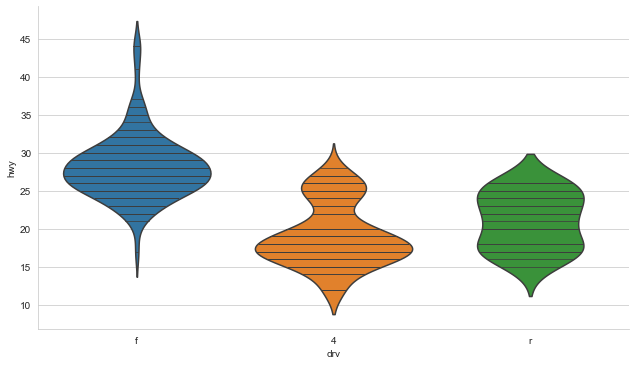

In [9]:
sns.catplot(data = mpg, x='drv', y='hwy', kind='violin', inner='stick', aspect = 1.75)

plt.show()

Lastly, we can just show the violin plot.

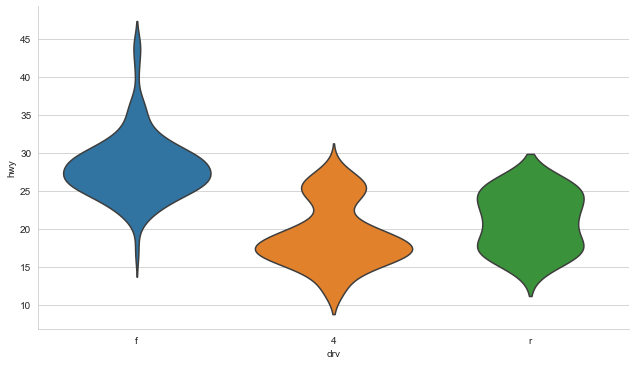

In [10]:
sns.catplot(data = mpg, x='drv', y='hwy', kind='violin', inner=None, aspect = 1.75)

plt.show()

It can be useful to only show the violin when we want to include a swarmplot to get a sense of whether the density estimate is appropriate for the underlying data.

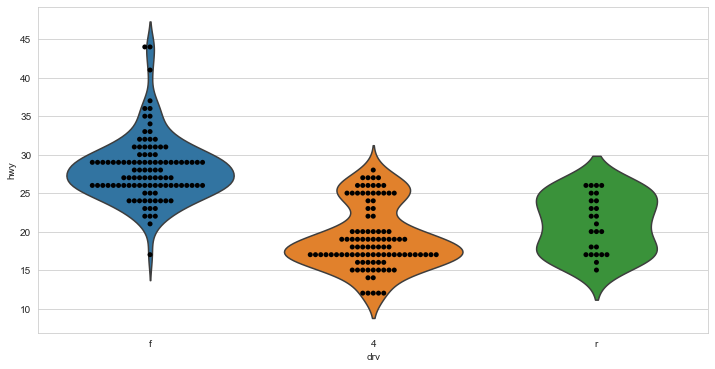

In [11]:
fig, ax = plt.subplots(figsize = (12, 6)) 

sns.violinplot(data = mpg, x='drv', y='hwy', inner=None, ax=ax)

sns.swarmplot(data = mpg, x='drv', y='hwy', color='k', ax=ax)

plt.show()

We can also modify the bandwidth of the violin plot density estimate if we'd like. The swarmplot can be especially useful when we do that because we can get a sense if our density is "too wiggly" for the data. For example the bandwidth used in the cell below is too small, causing the density to find any behavior present in the data. Essentially the density estimate is "overfit" to the observations.

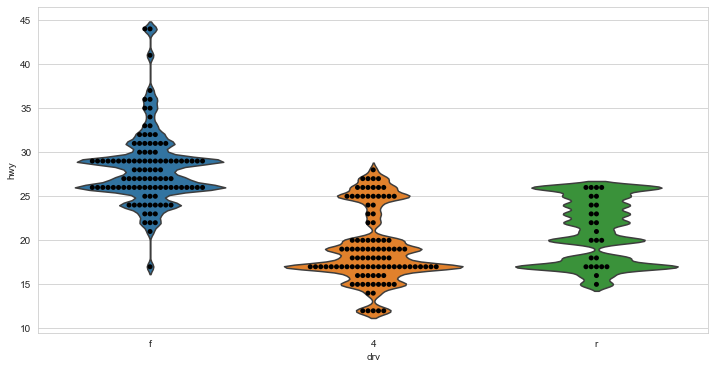

In [12]:
fig, ax = plt.subplots(figsize = (12, 6)) 

sns.violinplot(data = mpg, x='drv', y='hwy', bw=0.1, inner=None, ax=ax)

sns.swarmplot(data = mpg, x='drv', y='hwy', color='k', ax=ax)

plt.show()

Alternatively, the example below uses an overly large bandwidth, which smooths out any non-Gaussian behavior. That's why the resulting density estimate looks like a Gaussian for each group.

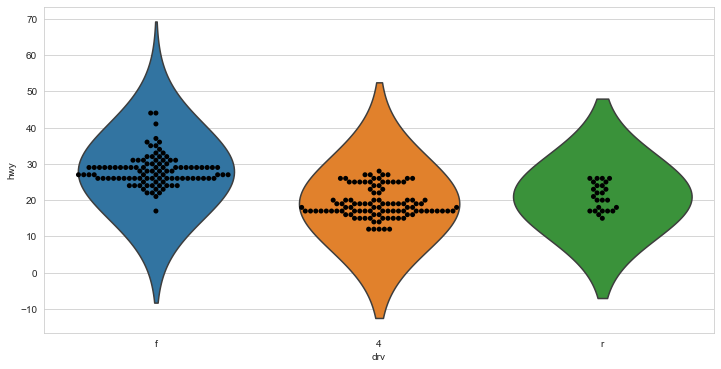

In [13]:
fig, ax = plt.subplots(figsize = (12, 6)) 

sns.violinplot(data = mpg, x='drv', y='hwy', bw=3, inner=None, ax=ax)

sns.swarmplot(data = mpg, x='drv', y='hwy', color='k', ax=ax)

plt.show()

The default bandwidth used in the violin plot comes from a reference rule. I usually just use the default behavior when exploring the data. 

## Compare average across groups

The previous figures focused on comparing the distributions across the categorical groups. Boxplots and eCDFs allow us to compare quantiles across the groups. Density plots, histograms, and violin plots let us compare the distributional shape across the groups. However, we will now ask a different question. We will consider if the **average** or **mean** behavior is different across the groups.

We can start out by calculating the average per group. We will continue to focus just on `hwy` for now.

In [14]:
mpg.groupby(['drv']).hwy.mean()

drv
4    19.174757
f    28.160377
r    21.000000
Name: hwy, dtype: float64

We can see the values are different. But, how confident are we that they are different? We need to consider the standard error on the mean!

In [15]:
mpg.groupby(['drv']).hwy.sem()

drv
4    0.401887
f    0.408608
r    0.732575
Name: hwy, dtype: float64

Let's create a grouped and summarized data set for the `hwy` value per `drv` group.

In [16]:
drv_group_summary = mpg.groupby(['drv']).\
aggregate(avg_hwy = ('hwy', 'mean'),
          avg_hwy_se = ('hwy', 'sem')).\
reset_index()

The 95% confidence interval on the average is approximately equal to two times the standard error.

In [17]:
drv_group_summary['avg_hwy_lwr'] = drv_group_summary.avg_hwy - 2 * drv_group_summary.avg_hwy_se

drv_group_summary['avg_hwy_upr'] = drv_group_summary.avg_hwy + 2 * drv_group_summary.avg_hwy_se

The 95% confidence interval on the average per group is:

In [18]:
drv_group_summary.loc[:, ['drv', 'avg_hwy_lwr', 'avg_hwy', 'avg_hwy_upr']]

,drv,avg_hwy_lwr,avg_hwy,avg_hwy_upr
0,4,18.370984,19.174757,19.978531
1,f,27.343161,28.160377,28.977594
2,r,19.534849,21.000000,22.465151


Rather than just comparing these intervals in a table, it's better to display the sample average and confidence intervals graphically. This way we can easily compare more than just 3 groups if there are more groups in the data. We don't have to go through creating the grouped and summarized data set to create that figure. Seaborn's point plot will calculate the average and include the confidence interval on the sample average for us. The confidence interval is specified by the `ci` argument. The default is 95, but the example below shows how to set `ci` to the default value.

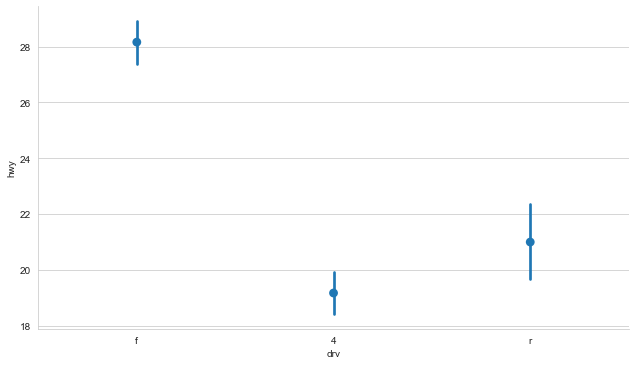

In [19]:
sns.catplot(data = mpg, x='drv', y='hwy', kind='point', ci=95, join=False, aspect=1.75)

plt.show()

## Iris data

Let's practice comparing the averages across the groups with the `iris` data set.

In [20]:
import statsmodels.api as sm

In [21]:
iris = sm.datasets.get_rdataset('iris').data

Let's first check the distributions of `Sepal.Length` across the `Species` groups using violin plots.

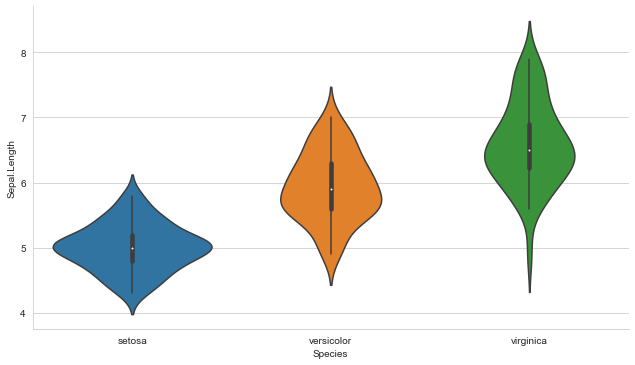

In [22]:
sns.catplot(data = iris, x='Species', y='Sepal.Length', kind='violin', aspect=1.75)

plt.show()

Let's now calculate the sample average and include the 95% confidence interval on the mean.

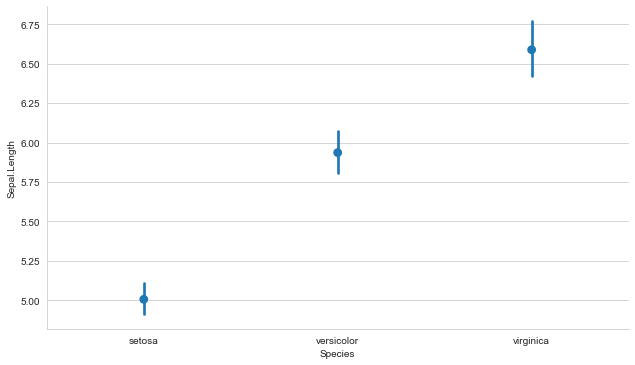

In [23]:
sns.catplot(data = iris, x='Species', y='Sepal.Length', kind='point', ci=95, join=False, aspect=1.75)

plt.show()